In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pylab as plt
import numpy as np
from mgemu import emu
import pyccl

In [5]:
def pmg(Om, h, ns, s8, fR0, n, z):
    Omh2 = (h**2)*Om
    pkratio, k = emu(Omh2, ns, s8, fR0, n, z)
    # cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
    cosmo = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    a = 1./(1+z)
    pk_nl = pyccl.nonlin_matter_power(cosmo, k, a)
    pk_mg = pk_lcdm*pkratio
    return pk_mg, k

In [6]:
#Defining function to calculate galaxy power spectrum, using the matter Pk from function pmg
#Additional arguments needed are linear bias b1& snot noise term shot
def p_ggmg(Om, h, ns, s8, fR0, n, z, b1, shot):
    Omh2 = (h**2)*Om
    pkratio, k = emu(Omh2, ns, s8, fR0, n, z)
    cosmo = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    a = 1./(1+z)
    pk_nl = pyccl.nonlin_matter_power(cosmo, k, a)
    pk_mg = pk_lcdm*pkratio
    pgg_mg = b1*b1*pk_mg + shot
    return pgg_mg, k

In [7]:
### LCDM parameters
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
### Hu-Sawicki model parameters
fr0=1e-5
n=1
### Redshift
z=0.0

In [8]:
pkratio, k = emu(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=z)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [9]:
# cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
cosmo = pyccl.Cosmology(Omega_c=Och2/(h**2), Omega_b=Obh2/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='bbks', matter_power_spectrum='emu')
#pyccl.comoving_radial_distance(cosmo, 1./(1+z))
a = 1./(1+z)
pk_lcdm = pyccl.nonlin_matter_power(cosmo, k, a)

In [58]:
#pk_lcdm = pyccl.nonlin_matter_power(cosmo, k, a)

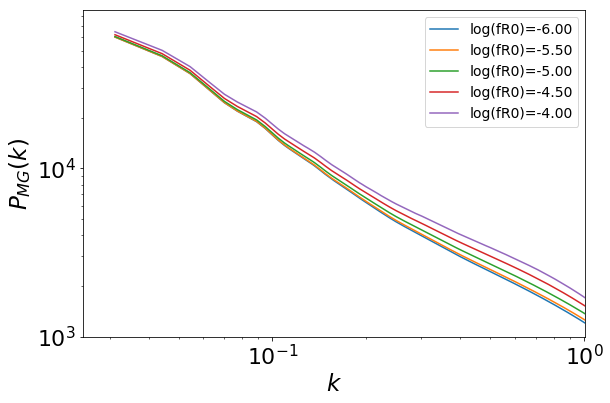

In [10]:
import matplotlib.pylab as plt
import numpy as np

plt.figure(1, figsize=(9, 6) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
b1 =1.2
shot = 10.0
for i in range(5):
    fR0 = fR0_arr[i]
    #p_mg, k = pmg(Om, h, ns, s8, fR0, n, z)
    p_gg, k = p_ggmg(Om, h, ns, s8, fR0, n, z, b1, shot)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    plt.plot(k, p_gg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{MG}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.xlim(0, 1.01)
plt.ylim(1e3,)


plt.show()

In [ ]:
#Now that we can evalute the galaxy Pk for a given MG cosmology, let's build functions to actually predict the galaxy bias and shot noise for a realistic LSST sample 

In [19]:
import math
from scipy.interpolate import interp1d
from scipy.integrate import quad, dblquad
from scipy.special import gamma
from scipy.integrate import odeint

In [20]:
#Define a-dependent functions for growth factor equation
def Omegatime(a, Om0):
 return Om0/(Om0+(1-Om0)*a*a*a)
#adot
def adot(a, Om0):
 return np.sqrt(Om0/a+(1-Om0)*a*a)
def H(a, Om0):
 return adot(a, Om0)/a
def adotprime(a, Om0):
 return (-Om0/a/a + 2*(1-Om0)*a)/np.sqrt(Om0/a+(1-Om0)*a*a)/2
#Define additional functions needed for
def mfr(a, Om0, fr0, nfr): #scalar field mass
 return (1/2997.72)*math.sqrt(1./(nfr+1)/fr0)*math.sqrt(math.pow(Om0+4*(1-Om0),-nfr-1))*math.sqrt(math.pow(Om0/a/a/a+4*(1-Om0),2+nfr))
#Define 1/adot^3 integrand
def invadot3(a, Om0):
 return 1/adot(a, Om0)/adot(a, Om0)/adot(a, Om0)
#Define 1/adot^3 integral
def intToday(Om0, amin):
 return quad(invadot3,0,amin,args=(Om0))[0]
def Damin(Om0, amin):
 return 2.5*Om0*H(amin, Om0)*intToday(Om0, amin)
def DH1(a, Om0):
 return -3*Om0/(2*a*a*a*math.sqrt((a*a*a+Om0-Om0*a*a*a)/a))
def der0(Om0, amin):
 return 2.5*Om0*(DH1(amin, Om0)*intToday(Om0, amin)+H(amin, Om0)*invadot3(amin, Om0))

In [21]:
#Setup integration to get comoving volume for various z bin
#Comoving distance integrator
def integrand(a, Omm):
 return 1/math.sqrt(a*Omm+a*a*a*a*(1-Omm))
#get comoving volume
def Vcom(z, Omm):
 return (4*math.pi*20000)/(3*41252.96)*math.pow(2997.92458*quad(integrand, 1./(1+z), 1, args=(Omm))[0],3)#*math.pow(10,-9)
#get comoving differential volume in redshift bin with width +-0.05
def Vbin(z, Omm, bin):
 return Vcom(z+bin, Omm)-Vcom(z-bin, Omm)
Veff=np.vectorize(Vbin)

#Define function fro differential dN/dz to be integrated
def dNdz(z, alpha, z0, ntot):
 return (ntot*alpha/(z0*gamma(3.0/alpha)))*(z/z0)*(z/z0)*math.exp(-math.pow(z/z0,alpha))
def Nz(z, alpha, z0, ntot, bin):
 return quad(dNdz, z-bin, z+bin, args=(alpha, z0, ntot))[0]

In [22]:
#Setup basic parameters for year10&Y1 LSST photo-z samples
NY10=48*20000*3600
ay10= 0.90
z0y10 = 0.28
biny10 = 0.05
b1y10 = 0.95
#for year1 sample
NY1=18*20000*3600
ay1= 0.94
z0y1 = 0.26
biny1 = 0.1
b1y1 = 1.05

In [23]:
abserr = 1.0e-13
relerr = 1.0e-13
#Define growth factor differential equation system
def growth(y, a, Om0):
 D, w = y
 dyda = [w, -(adotprime(a, Om0) + 2*H(a, Om0))*w/adot(a, Om0) + 1.5*Omegatime(a, Om0)*H(a, Om0)*H(a, Om0)*D/adot(a, Om0)/adot(a, Om0)]
 return dyda
 
#y0 = [0.0019999999,0.999999999]
arange = np.logspace(math.log(0.002,10),math.log(1,10),1000)
#setting up boundary conditions
y0 = [Damin(Om, arange[0]),der0(Om, arange[0])]
sol = odeint(growth, y0, arange, args=(Om,), atol=abserr, rtol=relerr)
#Spline GR growth factor  solution and growth rate.
Dgr = interp1d(arange, sol[:,0], kind='cubic')
#and also growth rate
fgr = interp1d(arange, arange*sol[:,1]/sol[:,0], kind='cubic')

In [24]:
timesteps = np.loadtxt('timestepsCOLA.txt')
irangey10 = np.array([43,45,48,53,57,61,65,70,75,82])
irangey1 = np.array([43,48,57,65,75])
Nt = irangey10[irangey10.shape[0]-1]

Nseed=2000 #25

In [25]:
#Now iterate of different snapshots
for i in (irangey10):
 astep = timesteps[i,0]
 zstep = timesteps[i,1]
 #linear bias for galaxy sample, in our case Y10
 b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
 #b1=b1y1*Dgr(1)/Dgr(astep) #Bias for Y10
 print ('a,z,b_1=',astep, zstep, b1)

a,z,b_1= 0.4512 1.216313 1.7096583337348459
a,z,b_1= 0.4708 1.124045 1.6456546962166596
a,z,b_1= 0.5002 0.999201 1.5599659653732123
a,z,b_1= 0.5492 0.820831 1.439767025161967
a,z,b_1= 0.5884 0.699524 1.3598856418114824
a,z,b_1= 0.6276 0.593372 1.2915087247085664
a,z,b_1= 0.6668 0.4997 1.2325678673005813
a,z,b_1= 0.7158 0.397038 1.1697264998089825
a,z,b_1= 0.7648 0.307531 1.1166678302825324
a,z,b_1= 0.8334 0.199904 1.0553364364635143


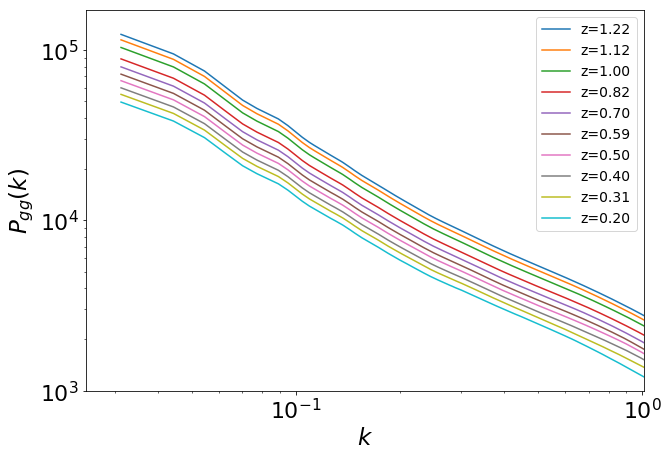

In [26]:
#Evaluate and Plot P_gg for 10 snapshots of the Y10 galaxy sample
plt.figure(1, figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_gg, k = p_ggmg(Om, h, ns, s8, fR0, n, zstep, b1, shot)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    plt.plot(k, p_gg, label = "z={:.2f}".format(zstep) )
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{gg}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.xlim(0, 1.01)
plt.ylim(1e3,)


plt.show()

In [29]:
print (Nseed, k.shape[0],((Nseed-k.shape[0]-2)/(Nseed-1)))
#Import covariance matrices
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    locals()['covPMGmat_'+str(i)] = np.loadtxt('./Covariance_data/covariance_step_'+str(i)+'.txt')
    locals()['InvcovPMGmat_'+str(i)] = ((Nseed-k.shape[0]-2)/(Nseed-1))*np.linalg.inv(locals()['covPMGmat_'+str(i)])

2000 213 0.8929464732366184


In [30]:
kvec = k
def applyPlotStyle14():
 plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
 plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
 plt.tick_params(which='both',width=1.3)
 plt.grid(True)
 plt.xscale("log")
 plt.yscale("log")
 plt.xlim(kvec[0], kvec[kvec.shape[0]-1])
 plt.ylim(kvec[0], kvec[kvec.shape[0]-1])
 #plt.ylabel(r"$\frac{P_{MG}}{P_{\Lambda CDM}}$",fontsize=18)
 plt.xlabel(r"$k (h/Mpc)$",fontsize=18)
 plt.ylabel(r"$k (h/Mpc)$",fontsize=18)
 #plt.ylabel(r"$r (Mpc/h)$",fontsize=18)
 plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':12})

In [ ]:
#Get correlation matrix for step=43
covxx = np.sqrt(np.diag(covPMGmat_43))*np.identity(len(kvec))
invcoxx = np.linalg.inv(covxx)
corrPMGmat_43 = np.dot(invcoxx,np.dot(covPMGmat_43,invcoxx))
from matplotlib import gridspec
from matplotlib import cm
fig11=plt.figure('test')
ax=fig11.add_subplot(111)
applyPlotStyle14()
ax.set_title('Galaxy-Galaxy covariance')
#pltcov=ax.pcolormesh(kvec,kvec,covPMGmat_43, cmap='plasma')
pltcov=ax.pcolormesh(kvec,kvec,corrPMGmat_43, cmap='plasma')
fig11.colorbar(pltcov, ax=ax)
plt.tight_layout()
plt.show()

In [117]:
#Incomplete, continue later
#for i in (irangey10):
for i in range(0):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    Omh2up = Omh2 + 0.003
    Omh2down = Omh2 - 0.003
    Omup = Omh2up/h/h
    Omdown = Omh2down/h/h
    p_ggup, k = p_ggmg(Omup, h, ns, s8, fR0, n, zstep, b1, shot)
    p_ggdown, k = p_ggmg(Omdown, h, ns, s8, fR0, n, zstep, b1, shot)
    derOmh = (p_ggup-p_ggdown)/2/0.003